# Debug

Debug the problems

## Preamble

In [1]:
import os 
import h5py
import bilby
from bilby.core.prior import Uniform
import numpy as np
import matplotlib.pyplot as plt
import warnings

bilby_keys = ["chirp_mass",
              "mass_ratio",
              "chi_1",
              "chi_2",
              "luminosity_distance",
              "geocent_time",
              "phase",
              "theta_jn",
              "psi",
              "ra",
              "dec"
]

## Setup

In [2]:
duration = 4.0
post_trigger_duration = 4.0
sampling_frequency = 4096.0

fmin = 20.0
fmax = 2048.0

outdir = "outdir"
label = "test"
bilby.core.utils.setup_logger(outdir=outdir, label=label)


injection_parameters = {'chirp_mass': 60.0, 'mass_ratio': 0.65, 'chi_1': 0.117373469793956438, 'chi_2': 0.5308517575336058, 'luminosity_distance': 2500, 'dec': 2.5, 'ra': 2.5, 'theta_jn': 2.5, 'psi': 0.4, 'phase': 0.4, 'geocent_time': 0.0}

# Fixed arguments passed into the source model
waveform_arguments = dict(
    waveform_approximant="IMRPhenomD",
    reference_frequency=20.0,
    minimum_frequency=fmin,
    maximum_frequency=fmax,
)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)

ifos = bilby.gw.detector.InterferometerList(["H1", "L1", "V1"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 2, # TODO: check this?
)

ifos.inject_signal(
    waveform_generator=waveform_generator, 
    parameters=injection_parameters
)

# priors = bilby.gw.prior.BBHPriorDict()
chirp_mass = Uniform(name='chirp_mass', minimum=25, maximum=100)
mass_ratio = Uniform(name='mass_ratio', minimum=0.125, maximum=1)
chi_1 = Uniform(name='chi_1', minimum=-0.99, maximum=0.99)
chi_2 = Uniform(name='chi_2', minimum=-0.99, maximum=0.99)
luminosity_distance = Uniform(name='luminosity_distance', minimum=5e2, maximum=4e3)
geocent_time = Uniform(name='geocent_time', minimum=-0.01, maximum=0.01)
phase = Uniform(name='phase', minimum=0, maximum=2 * np.pi)
theta_jn = Uniform(name='theta_jn', minimum=0, maximum=2*np.pi)
psi = Uniform(name='psi', minimum=0, maximum=np.pi)
dec = Uniform(name='dec', minimum=0, maximum=2*np.pi)
ra = Uniform(name='ra', minimum=0, maximum=2 * np.pi)

priors = dict(
    chirp_mass=chirp_mass,
    mass_ratio=mass_ratio,
    chi_1=chi_1,
    chi_2=chi_2,
    luminosity_distance=luminosity_distance,
    geocent_time=geocent_time,
    phase=phase,
    theta_jn=theta_jn,
    psi=psi,
    dec=dec,
    ra=ra,
)

time_delay = ifos[0].time_delay_from_geocenter(
    injection_parameters["ra"],
    injection_parameters["dec"],
    injection_parameters["geocent_time"],
)
priors["H1_time"] = bilby.core.prior.Uniform(
    minimum=injection_parameters["geocent_time"] + time_delay - 0.1,
    maximum=injection_parameters["geocent_time"] + time_delay + 0.1,
    name="H1_time",
    latex_label="$t_H$",
    unit="$s$",
)

likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos,
    waveform_generator=waveform_generator,
    priors=priors,
    distance_marginalization=False,
    phase_marginalization=False,
    time_marginalization=False,
    reference_frame="H1L1V1",
    time_reference="H1",
)

# # Run sampler. In this case we're going to use the `dynesty` sampler
# # Note that the `walks`, `nact`, and `maxmcmc` parameter are specified
# # to ensure sufficient convergence of the analysis.
# # We set `npool=4` to parallelize the analysis over four cores.
# # The conversion function will determine the distance posterior in post processing
# result = bilby.run_sampler(
#     likelihood=likelihood,
#     priors=priors,
#     sampler="dynesty",
#     nlive=1000,
#     walks=20,
#     nact=50,
#     maxmcmc=2000,
#     npool=4,
#     injection_parameters=injection_parameters,
#     outdir=outdir,
#     label=label,
#     conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
#     result_class=bilby.gw.result.CBCResult,
# )

# # Plot the inferred waveform superposed on the actual data.
# result.plot_waveform_posterior(n_samples=1000)

# # Make a corner plot.
# result.plot_corner()

13:36 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


/home/urash/twouters/bilby/bilby/gw/source.py:528: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
13:36 bilby INFO    : Injected signal in H1:
13:36 bilby INFO    :   optimal SNR = 21.97
13:36 bilby INFO    :   matched filter SNR = 21.32-0.21j
13:36 bilby INFO    :   chirp_mass = 60.0
13:36 bilby INFO    :   mass_ratio = 0.65
13:36 bilby INFO    :   chi_1 = 0.11737346979395644
13:36 bilby INFO    :   chi_2 = 0.5308517575336058
13:36 bilby INFO    :   luminosity_di

## Investigate likelihood attrs

Let's see what has been put into the likelihood

In [3]:
likelihood.__dict__

{'waveform_generator': WaveformGenerator(duration=4.0, sampling_frequency=4096.0, start_time=-2.0, frequency_domain_source_model=lal_binary_black_hole, time_domain_source_model=None, parameter_conversion=convert_to_lal_binary_black_hole_parameters, waveform_arguments={'waveform_approximant': 'IMRPhenomD', 'reference_frequency': 20.0, 'minimum_frequency': 20.0, 'maximum_frequency': 2048.0}),
 'parameters': {},
 '_meta_data': None,
 '_marginalized_parameters': [],
 '_interferometers': [Interferometer(name='H1', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='/home/urash/twouters/bilby/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), minimum_frequency=20.0, maximum_frequency=2048.0, length=4.0, latitude=46.45514666666667, longitude=-119.4076571388889, elevation=142.554, xarm_azimuth=125.9994, yarm_azimuth=215.9994, xarm_tilt=-0.0006195, yarm_tilt=1.25e-05),
  Interferometer(name='L1', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='/hom

## Likelihood evaluations

In [4]:
outdir = "/home/urash/twouters/projects/jim_meets_harmonic/11d_runs/working_3/"
bilby_results_file = os.path.join(outdir, 'bilby/bbh_0_result.hdf5')
with h5py.File(bilby_results_file, 'r') as f:
    bilby_posterior_dict = f["posterior"]
    bilby_posterior = np.array([bilby_posterior_dict[key] for key in bilby_keys]).T
    
    log_noise_evidence = f["log_noise_evidence"][()]
    log_evidence = f["log_evidence"][()]
    
    # Fetch truths
    truths_dict = f["injection_parameters"]
    truths = []
    for key in bilby_keys:
        truths.append(truths_dict[key][()])
    truths = np.array(truths)
    
    log_likelihood = bilby_posterior_dict["log_likelihood"][()]
    log_prior = bilby_posterior_dict["log_prior"][()]
    log_prob = log_likelihood + log_prior
    avg_log_prob = np.mean(log_prob)
    
    print(f"Mean log likelihood bilby: {np.mean(log_likelihood)}")
    print(f"Mean log prob bilby: {avg_log_prob}")
    avg_log_prior = np.mean(log_prior)
    print(f"Mean log prob bilby: {avg_log_prior}")
    
print(np.shape(bilby_posterior))

Mean log likelihood bilby: 401.7991660742341
Mean log prob bilby: 383.5042822703733
Mean log prob bilby: -18.294883803860813
(5030, 11)


In [5]:
likelihood.parameters.update(injection_parameters)
print(likelihood.log_likelihood())

13:36 bilby WARNING : Cannot find H1_time in parameters. Falling back to geocent time
13:36 bilby WARNING : Cannot convert from zenith/azimuth to ra/dec falling back to provided ra/dec


371.2146199045661


## On the jim samples

In [6]:
LOG_PRIOR_VALUE = -18.294883803860813

jim_file = "./working_3/jim/results_production.npz"
data = np.load(jim_file)
chains = data["chains"]
chains = np.reshape(chains, (-1, chains.shape[-1]))
log_prob = data["log_prob"]
log_prob = np.reshape(log_prob, (-1, ))

jim_naming = ["M_c", "q", "s1_z", "s2_z", "d_L", "t_c", "phase_c", "iota", "psi", "ra", "dec"]

# translating keys from bilby to jim
translation = {"chirp_mass": "M_c",
               "mass_ratio": "q",
               "chi_1": "s1_z",
                "chi_2": "s2_z",
                "luminosity_distance": "d_L",
                "geocent_time": "t_c",
                "dec": "dec",
                "ra": "ra",
                "theta_jn": "iota",
                "psi": "psi",
                "phase": "phase_c",
                "geocent_time": "t_c"
               }

def get_jim_vals(idx):
    """Get the values as dictionary for bilby consumption at specific idx in the jim chains"""
    new_vals = {}
    for name in likelihood.parameters.keys():
        if name in translation:
            new_vals[name] = chains[idx, jim_naming.index(translation[name])]
        else:
            raise ValueError(f"Key {name} not found in translation")
        
    return new_vals

In [7]:
idx_list = np.arange(0, 100, 1)

bilby_L = []
jim_L = []

for idx in idx_list:
    new_vals = get_jim_vals(idx)
    likelihood.parameters.update(new_vals)
    bilby_L.append(likelihood.log_likelihood())
    jim_L.append(log_prob[idx])
    
bilby_L = np.array(bilby_L)
jim_L = np.array(jim_L)
diff = bilby_L - jim_L


13:36 bilby WARNING : Cannot find H1_time in parameters. Falling back to geocent time
13:36 bilby WARNING : Cannot convert from zenith/azimuth to ra/dec falling back to provided ra/dec


13:36 bilby WARNING : Cannot find H1_time in parameters. Falling back to geocent time
13:36 bilby WARNING : Cannot convert from zenith/azimuth to ra/dec falling back to provided ra/dec
13:36 bilby WARNING : Cannot find H1_time in parameters. Falling back to geocent time
13:36 bilby WARNING : Cannot convert from zenith/azimuth to ra/dec falling back to provided ra/dec
13:36 bilby WARNING : Cannot find H1_time in parameters. Falling back to geocent time
13:36 bilby WARNING : Cannot convert from zenith/azimuth to ra/dec falling back to provided ra/dec
13:36 bilby WARNING : Cannot find H1_time in parameters. Falling back to geocent time
13:36 bilby WARNING : Cannot convert from zenith/azimuth to ra/dec falling back to provided ra/dec
13:36 bilby WARNING : Cannot find H1_time in parameters. Falling back to geocent time
13:36 bilby WARNING : Cannot convert from zenith/azimuth to ra/dec falling back to provided ra/dec
13:36 bilby WARNING : Cannot find H1_time in parameters. Falling back to ge

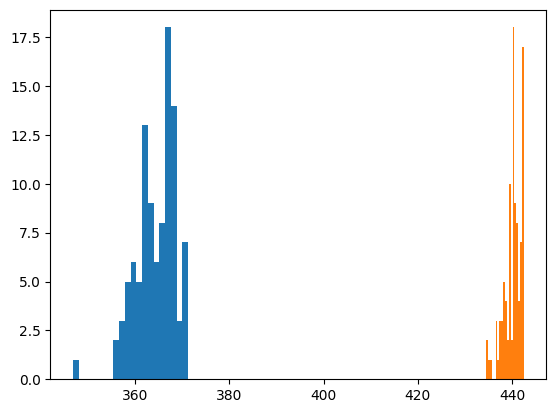

In [8]:
plt.hist(bilby_L, bins = 20)
plt.hist(jim_L, bins = 20)
plt.show()

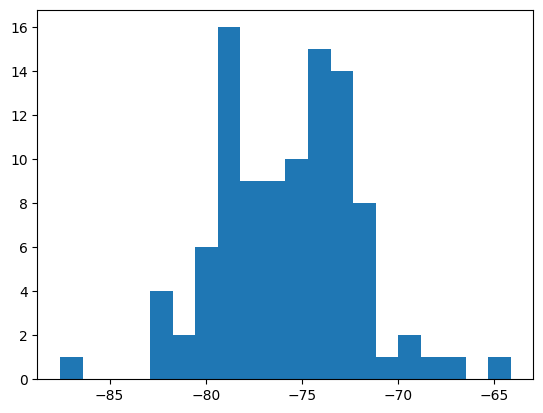

In [9]:
plt.hist(diff, bins = 20)
plt.show()

## Interferometers

In [16]:
for ifo in ifos:
    # print(ifo.meta_data)
    print(ifo.strain_data.duration)
    break

4.0


In [11]:
# from bilby.gw.detector import Interferometer
# from bilby.gw.detector.networks import InterferometerList

In [12]:
# # new_ifo = Interferometer()
# new_ifos = InterferometerList(["H1", "L1", "V1"])
# new_ifos

## Replicate the steps of parallel bilby

In [18]:
import pickle

In [34]:
datadump_file = "./outdir/out_bbh_0/data/bbh_0_data_dump.pickle"
with open(datadump_file, "rb") as f:
    data = pickle.load(f)
    
print(data.keys())
waveform_generator = data["waveform_generator"]
ifo_list = data["ifo_list"]
prior_file = data["prior_file"]
args = data["args"]
meta_data = data["meta_data"]
injection_parameters = data["injection_parameters"]

dict_keys(['waveform_generator', 'ifo_list', 'prior_file', 'args', 'data_dump_file', 'meta_data', 'injection_parameters'])
{'chirp_mass': 60.0, 'mass_ratio': 0.65, 'chi_1': 0.11737346979395644, 'chi_2': 0.5308517575336058, 'luminosity_distance': 2500.0, 'dec': 2.5, 'ra': 2.5, 'theta_jn': 2.5, 'psi': 0.4, 'phase': 0.4, 'geocent_time': 0.0, 'fiducial': 1.0}


In [42]:
args.time_reference

'geocent'

In [36]:
likelihood_kwargs = dict(
    interferometers=ifo_list,
    waveform_generator=waveform_generator
    priors=priors,
    phase_marginalization=args.phase_marginalization,
    distance_marginalization=args.distance_marginalization,
    distance_marginalization_lookup_table=args.distance_marginalization_lookup_table,
    time_marginalization=args.time_marginalization,
    reference_frame=args.reference_frame,
    time_reference=args.time_reference,
)